# Building a LangGraph RAG Pipeline

#### 1. Document Loading:

In [1]:
!pip install -qU langchain_community beautifulsoup4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00


In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 55.0 MB/s eta 0:00:00


In [3]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline



In [4]:
# Load a contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),  # URL to scrape
    bs_kwargs={
        "parse_only": bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    },
)

# Load the document
docs = loader.load()

In [5]:
print("\n First document preview:")
print(docs[0].page_content[:1000])  # Print the first 1000 characters


 First document preview:


      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Mem

In [6]:
print(f"Total number of documents: {len(docs)}")

Total number of documents: 1


In [7]:
total_chars_before_split = len(docs[0].page_content)
print(f" Total number of characters before splitting: {total_chars_before_split}")


 Total number of characters before splitting: 43130


In [8]:
# Verify if obect "docs" has attribut "metadata" and count him
if hasattr(docs[0], "metadata"):
    num_metadatas = len(docs[0].metadata)
    print(f" Total number of metadata in document {num_metadatas}")
    print("\n First document metadata:")
    print(docs[0].metadata)
else:
    print(" This document has no attribut `metadata`.")


 Total number of metadata in document 1

 First document metadata:
{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}


#### 2. Document Splitting

  * Use RecursiveCharacterTextSplitter to split the loaded document into smaller chunks.
  * Set chunk_size and chunk_overlap parameters to appropriate values.
  * Ensure add_start_index is set to track the original document position.
  * Verify the amount of created chunks.

In [9]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,    # Each chunk will contain at most 1000 characters
                                               chunk_overlap=200,  # Ensures 200 characters of overlap between consecutive chunks
                                               add_start_index=True  # Adds metadata to track the original position in the document
                                               )

# Split the loaded documents into smaller chunks
all_splits = text_splitter.split_documents(docs)

# Print number of created chunks
print(f"Now we have {len(all_splits)} splits.")


# Print metadata of the first chunk to verify start index
print("\n - First chunk metadata:")
print(all_splits[0].metadata)

Now we have 66 splits.

 - First chunk metadata:
{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 8}


3. Vector Store Indexing:

  * Embed the document chunks and store them in a vector store (you will need to setup a vector store and embedding model, like in the previous daily challenge).
  * Store the document id’s returned from the vector store.
  * Verify the document ID’s.

In [10]:
# Convert text chunks into vectors using an embedding model
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-l6-v2")

<ipython-input-10-6b03e18b9208>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-l6-v2")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or d

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [27]:
# Assign unique document IDs before storing in FAISS
for i, doc in enumerate(all_splits):
    doc.metadata["doc_id"] = f"doc_{i}"  # Assign a unique document ID

# Store the vectors in FAISS
vector_store = FAISS.from_documents(all_splits, embeddings)

In [28]:
query = "What's a chatbot?"
# Retrieve the top 3 most similar documents based on vector similarity
retrieved_docs = vector_store.similarity_search(query, k=3)

# Retrieve the top 3 most similar documents based on vector similarity
retrieved_docs = vector_store.similarity_search("test", k=3)

# Print retrieved document IDs and a preview of their content
print("\n Vérification des IDs des documents récupérés :")
for i, doc in enumerate(retrieved_docs):
    doc_id = doc.metadata.get("doc_id", " No ID Found")
    print(f" - Document {i+1} ID: {doc_id}")
    print(f" - Content: {doc.page_content[:200]}...")  # Show a preview of the content
    print("-" * 50)  # Separator for readability




 Vérification des IDs des documents récupérés :
 - Document 1 ID: doc_42
 - Content: 11. Delete file: "delete_file", args: "file": "<file>"
12. Search Files: "search_files", args: "directory": "<directory>"
13. Analyze Code: "analyze_code", args: "code": "<full_code_string>"
14. Get I...
--------------------------------------------------
 - Document 2 ID: doc_43
 - Content: Resources:
1. Internet access for searches and information gathering.
2. Long Term memory management.
3. GPT-3.5 powered Agents for delegation of simple tasks.
4. File output.

Performance Evaluation:...
--------------------------------------------------
 - Document 3 ID: doc_36
 - Content: They also discussed the risks, especially with illicit drugs and bioweapons. They developed a test set containing a list of known chemical weapon agents and asked the agent to synthesize them. 4 out o...
--------------------------------------------------


4. LangGraph Pipeline Setup:

In [14]:
from typing import TypedDict  # Import TypedDict for defining structured dictionaries

# Define application state structure as a dictionary with predefined keys
class QAState(TypedDict):
    question: str  # Stores the user's question
    context: str   # Stores the retrieved context from the vector database
    answer: str    # Stores the generated answer from the language model

print(" - Application state structure defined.")  # Confirmation message


 - Application state structure defined.


In [15]:
def retrieve(state: QAState) -> QAState:
    """Retrieve relevant document chunks from the FAISS vector store."""

    # Convert FAISS vector store into a retriever for similarity search
    retriever = vector_store.as_retriever(search_kwargs=dict(k=3))  # Retrieve top 3 most similar documents

    # Search FAISS and return relevant documents based on semantic similarity
    retrieved_docs = retriever.get_relevant_documents(state["question"])

    # Combine retrieved document contents into a single string
    context = "\n".join([doc.page_content for doc in retrieved_docs])

    print(f"\n  Retrieved {len(retrieved_docs)} relevant documents.")  # Display the number of retrieved documents

    # Return updated state with retrieved context added
    return {**state, "context": context}

In [16]:
# Load a local LLM model (NO API KEY NEEDED)
model_name = "google/flan-t5-small"  # Small version of Flan-T5 for text generation
tokenizer = AutoTokenizer.from_pretrained(model_name)  # Load tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)  # Load model

# Define text generation pipeline
generator = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Wrap the Hugging Face pipeline in LangChain's LLM wrapper
llm = HuggingFacePipeline(pipeline=generator)

def generate(state: QAState) -> QAState:
    """Generate an answer using the retrieved context and the LLM."""

    # Construct a prompt using the retrieved context and the question
    prompt = f"Context:\n{state['context']}\n\nQuestion: {state['question']}\nAnswer:"

    # Generate an answer using the LLM
    answer = llm.invoke(prompt)

    return {**state, "answer": answer}  # Update the state with the generated answer


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cpu
<ipython-input-16-177d316fe780>:10: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=generator)


In [31]:
import langchain.hub

# Load predefined RAG prompt template
rag_prompt = langchain.hub.pull("rlm/rag-prompt")
print(" - LangChain RAG prompt template loaded!")
print(rag_prompt)

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


 - LangChain RAG prompt template loaded!
input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


In [18]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00


In [19]:
!pip install --upgrade langgraph

In [20]:
!pip install --upgrade langgraph

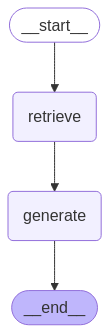

In [21]:
from langgraph.graph import StateGraph  # Import LangGraph for workflow management

# Define the graph structure
graph = StateGraph(QAState)  # Create a stateful graph using the QAState structure

# Add processing nodes to the graph
graph.add_node("retrieve", retrieve)  # Node for retrieving relevant documents
graph.add_node("generate", generate)  # Node for generating answers

# Define execution order
graph.set_entry_point("retrieve")  # Start execution at the retrieve step
graph.add_edge("retrieve", "generate")  # Connect retrieval → generation
graph.set_finish_point("generate")  # Mark generation as the final step

# Compile the workflow
app = graph.compile()  # Convert the defined structure into an executable pipeline

#  Visualize the LangGraph pipeline
from IPython.display import Image, display  # Import display tools for visualization
png = app.get_graph().draw_mermaid_png()  # Generate a diagram of the workflow

# Display the workflow graph
display(Image(png))


#### 5. Pipeline Execution

  * Use graph.invoke to execute the pipeline with a sample question.
  * Print the retrieved context and generated answer.



In [22]:
# Define a sample question for testing the pipeline
sample_question = "How do embedding databases work ?"

# Execute the pipeline with the user query
result = app.invoke({"question": sample_question})  # Pass the question to LangGraph for processing

# Print the retrieved context (FAISS results)
print(" **Retrieved Context:**")
print(result["context"])  # Display the most relevant document chunks

# Print the generated answer (LLM output)
print("\n **Generated Answer:**")
print(result["answer"])  # Display the AI-generated response


<ipython-input-15-20056b59f484>:8: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(state["question"])



  Retrieved 3 relevant documents.
 **Retrieved Context:**
LSH (Locality-Sensitive Hashing): It introduces a hashing function such that similar input items are mapped to the same buckets with high probability, where the number of buckets is much smaller than the number of inputs.
ANNOY (Approximate Nearest Neighbors Oh Yeah): The core data structure are random projection trees, a set of binary trees where each non-leaf node represents a hyperplane splitting the input space into half and each leaf stores one data point. Trees are built independently and at random, so to some extent, it mimics a hashing function. ANNOY search happens in all the trees to iteratively search through the half that is closest to the query and then aggregates the results. The idea is quite related to KD tree but a lot more scalable.
Fig. 8. Categorization of human memory.
We can roughly consider the following mappings:

Sensory memory as learning embedding representations for raw inputs, including text, image 

  * Use graph.stream with stream_mode="updates" to stream the pipeline steps.
  * Use graph.stream with stream_mode="messages" to stream the model responses.

In [23]:
# Monitor the pipeline execution in real time
print(" **Streaming pipeline execution (step-by-step updates)**")

# Stream execution steps using LangGraph's `stream` method
for event in app.stream({"question": sample_question}, stream_mode="updates"):
    print(event)  # Print each update as it occurs


 **Streaming pipeline execution (step-by-step updates)**

  Retrieved 3 relevant documents.
{'retrieve': {'question': 'How do embedding databases work ?', 'context': 'LSH (Locality-Sensitive Hashing): It introduces a hashing function such that similar input items are mapped to the same buckets with high probability, where the number of buckets is much smaller than the number of inputs.\nANNOY (Approximate Nearest Neighbors Oh Yeah): The core data structure are random projection trees, a set of binary trees where each non-leaf node represents a hyperplane splitting the input space into half and each leaf stores one data point. Trees are built independently and at random, so to some extent, it mimics a hashing function. ANNOY search happens in all the trees to iteratively search through the half that is closest to the query and then aggregates the results. The idea is quite related to KD tree but a lot more scalable.\nFig. 8. Categorization of human memory.\nWe can roughly consider the f

Test Async invocations.

In [24]:
import asyncio  # Import async library for non-blocking execution

async def async_execution():
    """Execute the RAG pipeline asynchronously."""

    sample_question = "How do embedding databases work ?"  # Define a test query

    # Run the pipeline in async mode using 'ainvoke'
    result = await app.ainvoke({"question": sample_question})

    #  Print the retrieved documents
    print("\n  **Async Retrieved Context:**")
    print(result["context"])  # Display retrieved document chunks

    #  Print the generated answer
    print("\n **Async Generated Answer:**")
    print(result["answer"])  # Display the AI-generated response

#  Run the Async Execution
await async_execution()  # Launch the async process



  Retrieved 3 relevant documents.

  **Async Retrieved Context:**
LSH (Locality-Sensitive Hashing): It introduces a hashing function such that similar input items are mapped to the same buckets with high probability, where the number of buckets is much smaller than the number of inputs.
ANNOY (Approximate Nearest Neighbors Oh Yeah): The core data structure are random projection trees, a set of binary trees where each non-leaf node represents a hyperplane splitting the input space into half and each leaf stores one data point. Trees are built independently and at random, so to some extent, it mimics a hashing function. ANNOY search happens in all the trees to iteratively search through the half that is closest to the query and then aggregates the results. The idea is quite related to KD tree but a lot more scalable.
Fig. 8. Categorization of human memory.
We can roughly consider the following mappings:

Sensory memory as learning embedding representations for raw inputs, including text

6. #### Evaluation and Experimentation:

  * Experiment with different questions and observe the retrieved context and generated answers.
  * Adjust the chunk_size and chunk_overlap parameters to see how they affect retrieval.
  * Adjust the prompt template.


In [30]:
# Define different chunk sizes to test
chunk_sizes = [500, 1000, 2000]  # Different chunk sizes to evaluate
chunk_overlap = 100  # Constant overlap between chunks

# Loop through different chunk sizes
for size in chunk_sizes:
    print(f"\n **Testing chunk_size={size}, chunk_overlap={chunk_overlap}**")

    # Re-split the documents with the new chunk size
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=size, chunk_overlap=chunk_overlap, add_start_index=True)
    new_splits = text_splitter.split_documents(docs)

    print(f" **Total chunks generated:** {len(new_splits)}")

    #  Store the new chunks in FAISS
    vector_store = FAISS.from_documents(new_splits, embeddings)
    print(" FAISS vector store updated with new chunks.")

    #  Test the LangGraph pipeline with different questions
    test_questions = [
        "What is vector search?",
        "How does FAISS work?",
        "How do embedding databases handle large datasets?",
    ]

    # Loop through test questions to evaluate retrieval and response quality
    for question in test_questions:
        print(f"\n **Testing question with chunk_size={size}:** {question}")
        result = app.invoke({"question": question})

        # Display retrieved context from FAISS
        print("\n **Retrieved Context:**")
        print(result["context"][:500])  # Show only the first 500 characters of the retrieved text

        # Display the generated answer from the LLM
        print("\n **Generated Answer:**")
        print(result["answer"])  # Show the AI-generated answer

        print("-" * 80)  # Separator for readability



 **Testing chunk_size=500, chunk_overlap=100**
 **Total chunks generated:** 132
 FAISS vector store updated with new chunks.

 **Testing question with chunk_size=500:** What is vector search?

  Retrieved 3 relevant documents.

 **Retrieved Context:**
[11] Nakano et al. “Webgpt: Browser-assisted question-answering with human feedback.” arXiv preprint arXiv:2112.09332 (2021).
[12] Parisi et al. “TALM: Tool Augmented Language Models”
[13] Schick et al. “Toolformer: Language Models Can Teach Themselves to Use Tools.” arXiv preprint arXiv:2302.04761 (2023).
[14] Weaviate Blog. Why is Vector Search so fast? Sep 13, 2022.
[15] Li et al. “API-Bank: A Benchmark for Tool-Augmented LLMs” arXiv preprint arXiv:2304.08244 (2023).
Maximum Inner Product Sea

 **Generated Answer:**
maximum inner-product search
--------------------------------------------------------------------------------

 **Testing question with chunk_size=500:** How does FAISS work?

  Retrieved 3 relevant documents.

 **Retrieve

**Rasults Analysis**

For the three tested questions, it seems that chunk_size = 1000 with overlap = 100 produces the best responses. Specifically:

  * With chunk_size = 500, responses are often incomplete or too short. The document chunks are too fragmented, reducing the relevance of the retrieved passages.
  * With chunk_size = 2000, responses sometimes include too much information, making it harder for the model to extract only the most relevant details.
  * With chunk_size = 1000 and overlap = 100, there is a good balance between context and precision, leading to clearer and more informative answers.
  
However, it is important to note that response quality does not depend solely on chunking but also on the prompt used. A well-structured and precise prompt can improve the relevance of the answers, even with suboptimal chunking.

In [34]:
from langchain import PromptTemplate, LLMChain

In [36]:
llm_chain_custom = LLMChain(llm=llm, prompt=custom_prompt)

#  New prompt
custom_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
    You are an AI assistant specialized in question-answering. Use the retrieved context below to answer the question.

    - If you don't find the answer in the context, say "I don't know".
    - If the answer requires explanation, provide a detailed but concise response.
    - Structure your response using bullet points if relevant.
    - Use at most 5 sentences for clarity.

    **Question:** {question}

    **Context:** {context}

    **Answer:**
    """
)

# Créer une nouvelle LLMChain avec le prompt amélioré
llm_chain_custom = LLMChain(llm=llm, prompt=custom_prompt)

# Define test questions
test_questions = [
    "What is vector search?",
    "How does FAISS work?",
    "How do embedding databases handle large datasets?",
    "What are the advantages of Pinecone over FAISS?",
    "What is Approximate Nearest Neighbors (ANN) in retrieval systems?"
]


for question in test_questions:
    print(f"\n  **Testing question:** {question}")

    # Execute the query with the existing pipeline (LangChain Hub prompt)
    result_old = app.invoke({"question": question})

    # Execute the query with the new custom prompt
    result_new = llm_chain_custom.run(question=question, context=result_old["context"])

    #  Compare responses
    print("\n **Retrieved Context:**")
    print(result_old["context"][:500])  # Display a preview of the retrieved context
    print("\n **Generated Answer (Old Prompt):**")
    print(result_old["answer"])  # Answer using the old prompt
    print("\n **Generated Answer (New Prompt):**")
    print(result_new)  # Answer using the new prompt
    print("-" * 100)   # Separator for readability



  **Testing question:** What is vector search?

  Retrieved 3 relevant documents.

 **Retrieved Context:**
Fig. 8. Categorization of human memory.
We can roughly consider the following mappings:

Sensory memory as learning embedding representations for raw inputs, including text, image or other modalities;
Short-term memory as in-context learning. It is short and finite, as it is restricted by the finite context window length of Transformer.
Long-term memory as the external vector store that the agent can attend to at query time, accessible via fast retrieval.

Maximum Inner Product Search (MIPS)#
Th

 **Generated Answer (Old Prompt):**
ANNOY search

 **Generated Answer (New Prompt):**
ANNOY
----------------------------------------------------------------------------------------------------

  **Testing question:** How does FAISS work?

  Retrieved 3 relevant documents.

 **Retrieved Context:**
FAISS (Facebook AI Similarity Search): It operates on the assumption that in high dimension

**Analysis of the New Prompt**

We tested a new RAG prompt against the previous one using the same retrieval setup (chunk size = 1000, overlap = 100). The results showed mixed improvements:

  * Some answers gained more context, but not always in a structured way.
  * Certain responses became vague or incomplete, such as "id" instead of a proper FAISS explanation.
  * Retrieval remained consistent, meaning the issue was more about answer formatting than document selection.

** Conclusion**

  * The new prompt did not significantly outperform the old one, though it added more context in some cases.
  *  However, conciseness and relevance were sometimes lost.
  *  Further prompt tuning, retrieval adjustments, and model selection could enhance clarity and accuracy.